# Flash Method Data Reduction Using ODRPACK 
 (c) Jozef Gembarovic 2015, 2017

 ODRPACK (Orthogonal Distance Regression  PACKage) Version 2.1 - see [manual](https://docs.scipy.org/doc/external/odrpack_guide.pdf)


### Two Dimensional Model with Heat Losses and Exponential Pulse of a Finite Duration
Analytical formula for the temperature response at the rear face of a cylidrical sample after an exponential pulse described as 

$$ \psi(t)=\frac{t}{t_p^2}e^{-t/t_p},$$

with the maximum at $t_p$, is 

$$ T(t, a, B_0, B_1, B_2, t_p) = \sum_{m=0}^\infty \sum_{n=0}^\infty\Psi_m(a,B_0,B_1)\Phi_n(a,B_2)\Gamma_{mn}(t, t_p), $$

where $\Psi$ and $\Phi$ are axial and radial components:

$$ \Psi_m(t,a,B_0,B_1) =  \frac{ 2\gamma_m^2(\gamma_m^2+B_1^2)\big(\cos{\gamma_m}+\frac{B_0}{\gamma_m}\sin{\gamma_m}\big)}{(\gamma_m^2+B_0^2)(\gamma_m^2+B_1^2)+(B_0+B_1)(\gamma_m^2+B_0B_1)},$$


$$\Phi_n(t,a,B_2)=\frac{4\big(r_iJ_1(\beta_nr_i)-r_oJ_1(\beta_n r_o)\big)\big(R_iJ_1(\beta_n R_i)-R_oJ_1(\beta_n R_o)\big)}{(\beta_n^2+B_2^2)J_0(\beta_n)^2(R_o^2-R_i^2)(r_o^2-r_i^2)}, $$

$$\Gamma_{mn}=\bigg(\frac{L^2}{at_p}\bigg)^2\frac{e^{-t/t_p}}{\sigma_{mn}^2}\bigg[ \exp\bigg( - \sigma_{mn}\frac{at}{L^2}\bigg)+\sigma_{mn}\frac{at}{L^2}-1\bigg],$$

$$ \sigma_{mn}=\beta_n^2+\gamma_m^2\frac{L^2}{R^2}-\frac{L^2}{at_p}.$$

$\gamma_m$ and $\beta_n$, $m,n = 0,1,2,3,\dots$, are positive roots of 

$$ (\gamma^2-B_0B_1)\sin{\gamma} - (B_0+B_1)\cos{\gamma}=0,$$

$$ \beta J_1(\beta) - B_2J_0(\beta)=0. $$

$J_0(x)$ and $J_1(x)$ are Bessel functions of the 1st kind, $R$ is the sample radius.  $R_i$ and $R_o$ are the heat pulse inner and outer radii, $r_i$ and $r_o$ are the viewed area inner and outer radii. Irradiated area and the viewed area radii are dimensionles, relative to the sample radius $R$. $B_0$ and $B_1$ are Biot numbers for the front and rear face, respectively, while $B_2$ is the Biot number for the lateral side of the sample. The heat pulse is coaxial to the sample main axis and the viewed area center is in the center of the rear face of the sample.


In [2]:
%pylab inline

import numpy as np # for Numerical Python
import scipy.special as scs # for Bessel functions 
from scipy.optimize import brenth # for finding zeroes of a function
import scipy.odr.odrpack as odrpack #  for ODRPACK
import os # for files manipulatios (operating system package)
from matplotlib import pyplot # for plots
from matplotlib import gridspec # for resizing figures

Populating the interactive namespace from numpy and matplotlib


### Define sample geometry parameters and their values (in CGS units)



In [3]:
L = 0.10 #  sample thickness 
R = 6.35 # sample radius
IRI = 0.0 # irradiated radius inner
IRO = 5.35 # irradiated radius outer
VRI = 0.0 # viewed radius inner
VRO = 4.1 # viewed radius outer

### Define dimensionless radii and functions for roots calculations

In [4]:
# calculate dimensionless radii
IRID = IRI/R
IROD = IRO/R
VRID = VRI/R
VROD = VRO/R

def rootsearch(f,a,b,Bio,dx):
    x1 = a; f1 = f(a, Bio)
    x2 = a + dx; f2 = f(x2, Bio)
    while f1*f2 > 0.0:
        if x1 >= b:
            return None,None
        x1 = x2; f1 = f2
        x2 = x1 + dx; f2 = f(x2, Bio)
    return x1,x2


def mroots(f, Bio, a, b, eps=1e-2):
    #print ('The roots on the interval [%f, %f] are:' % (a,b))
    i=0
    myroots=[]
    while 1:
        x1,x2 = rootsearch(f,a,b,Bio,eps)
        if x1 != None:
            a = x2
            #root = bisect(f,x1,x2,1)
            root = brenth(f,x1,x2, Bio, xtol=1e-16)
            if root != None:
                pass
       #     print ('root',i, root, f(root, Bio))
            myroots.append(root)
            i = i+1
        else:
            #print ('\nDone')
            return myroots
            
            break

# transcendental functions for eigenvalues calculations
def funA(x,Bio): 
    return (x*x-Bio[0]*Bio[1])*np.sin(x) - (Bio[0]+Bio[1])*x*np.cos(x)
    
def funR(x,Bio): 
    return (x*scs.j1(x) - Bio[2]*scs.j0(x))

### Model functions

In [5]:
def flash2DHLe(t, a, Bio, gamas, betas, tp): 
    # Two dimensional model with heat losses and an exponential pulse 
    # with maximum at tp
    Bi1=Bio[0]
    Bi2=Bio[1]
    Bi3=Bio[2]
    
    gamas = np.array(gamas)
    betas = np.array(betas)
    g2 = gamas**2
    b2 = betas**2
    
    Fo = a*t/L**2
    iFop = L**2/a/tp
    ettp = np.exp(-t/tp)
    # radial spatial component
    sumaR = (VRID*scs.j1(betas*VRID) # n
            -VROD*scs.j1(betas*VROD))*(IRID*scs.j1(betas*IRID)
            -IROD*scs.j1(betas*IROD))/((b2+Bi3**2)*scs.j0(betas)**2)
    # axial spatial component
    sumaA = g2*(g2+Bi2**2)/((g2+Bi1**2)*(g2+Bi2**2) # m
            +(Bi1+Bi2)*(g2+Bi1*Bi2))*(np.cos(gamas)+Bi1/gamas
            *np.sin(gamas))
    
    # mix of spatial and temporal components
    sumaAll = 0.0
    for m in range(0, len(gamas)):
        for n in range(0, len(betas)):
            sigma = g2[m] + (betas[n]*L/R)**2 - iFop
            Gmn = (iFop/sigma)**2*ettp*(np.exp(-sigma*Fo)+sigma*Fo-1.0)
            sumaAll = sumaAll + sumaA[m]*sumaR[n]*Gmn
            
    return 8*sumaAll/((IROD**2-IRID**2)*(VROD**2-VRID**2))

In [6]:
def flash2DHL0(t, a, Bio, gamas, betas): 
    # Two dimensional model with heat losses, instantaneous pulse 
    Bi1=Bio[0]
    Bi2=Bio[1]
    Bi3=Bio[2]
    
    gamas = np.array(gamas)
    betas = np.array(betas)
    g2 = gamas**2
    b2 = betas**2
    
    # Axial component 
    nom   = 2*g2*(g2+Bi2**2)*(np.cos(gamas)+Bi1/gamas*np.sin(gamas))
    denom = (g2+Bi1**2)*(g2+Bi2**2)+(Bi1+Bi2)*(g2+Bi1*Bi2)
    expon = np.exp(-g2*a*t/L**2)
    SA = nom/denom*expon
    
    # Radial component 
    nomr = 4*(VRID*scs.j1(betas*VRID)-VROD*scs.j1(betas*VROD))*(IRID*scs.j1(betas*IRID)-IROD*scs.j1(betas*IROD))
        
    denomr = (b2+Bi3**2)*scs.j0(betas)**2*(IROD**2-IRID**2)*(VROD**2-VRID**2)
        
    exponr = np.exp(-b2*a*t/R**2)
    SR = nomr/denomr*exponr
    
    trise = SA.sum() * SR.sum() 
    
    return trise

### Simulate 'experimental' data
using the Two Dimensional model functions 

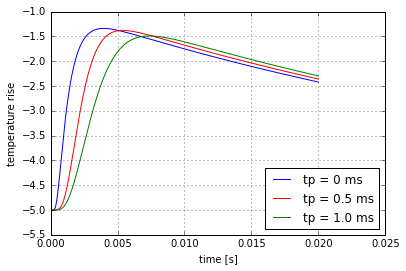

In [7]:
N=1000 # number of experimental points
time = np.linspace(0.0001,0.02,N) # define time points in seconds
noise = 0.05 # sigma (relative to Tmax) for noise level
# Theoretical values
# my theoretical values used for calculation 
# of 'experimental' data, feel free to change them!
baseline_theor = -5.0
Tmax_theor = 3.0  # Tmax 
td_theor = 1.17 # thermal diffusivity in cm^2/s (Copper at RT)
Biot_theor  = 0.1 # Biot number

tp1 = 0.0005         # maximum of the exponential shape heat pulse in seconds

tp2 = 0.001        # maximum of the exponential shape heat pulse in seconds
 
# new vector of theoretical parameters 
theors = [baseline_theor, Tmax_theor, td_theor, Biot_theor] 

# define front, rear and radial Biot numbers 
Bio = [Biot_theor, Biot_theor, Biot_theor*L/R]

# calculate eigenvalues - roots of the transcendental functions
gamas = mroots(funA, Bio, 0.0001, 200)
betas = mroots(funR, Bio, 0.0001, 200)


# calculate the temperature for 2DHL1 (without loops)
temperature0= (baseline_theor + Tmax_theor*
np.array(list(map(lambda x:flash2DHL0(x,td_theor, Bio, gamas, betas), time))))


# calculate two temperature rise curves using flash2DHLe with a finite exponential pulse
temperature1=(baseline_theor + Tmax_theor*flash2DHLe(time,td_theor, Bio, gamas, betas,tp1))
temperature2=(baseline_theor + Tmax_theor*flash2DHLe(time,td_theor, Bio, gamas, betas,tp2))

# calculate simulated data (noisy)
temperature1n = (baseline_theor + Tmax_theor*flash2DHLe(time,td_theor, Bio, gamas, betas,tp1)
+np.random.normal(0,noise,N))

# plot Colculated Data
pyplot.plot(time, temperature0,'b', label='tp = 0 ms') 
pyplot.plot(time, temperature1,'r', label='tp = 0.5 ms') 
pyplot.plot(time, temperature2,'g', label='tp = 1.0 ms') 
pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.legend(loc=4)
pyplot.grid()
pyplot.show()

# it is clear that the pulse shape and duration are important for a shape of 
# response curve of 1 mm thick Copper sample !!!

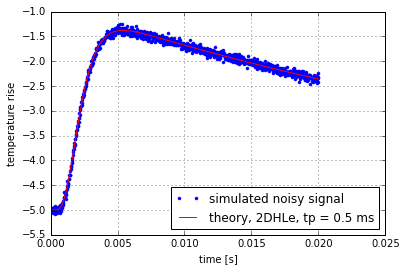

In [8]:
# plot simulated data
pyplot.plot(time, temperature1n,'b.', label='simulated noisy signal') 
pyplot.plot(time, temperature1,'r', label='theory, 2DHLe, tp = 0.5 ms') 

pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.legend(loc=4)
pyplot.grid()
pyplot.show()

### Here goes ODRPACK

In [9]:
# first delete the file 'filename' if it already exist to
# make room for a new one, generated by the ODRPACK
filename="res2DHLexpODR.txt" 
## delete only if file exists ##
if os.path.exists(filename):
    os.remove(filename)
else:
    print("Sorry, I can not remove %s file." % filename)
    
# define analytical function for temperature distribution used by the fitting procedure
# (tp value is assumed to be known)
def f2DHLe(B, t):
    Bio = [B[3], B[3], B[3]*L/R]
    gamas = mroots(funA, Bio, 0.0001, 100) # calculate the first ~ 80 positive roots
    betas = mroots(funR, Bio, 0.0001, 100) 
    return B[0]+B[1]*flash2DHLe(t,B[2], Bio, gamas, betas, tp1) 
flash = odrpack.Model(f2DHLe) # our model will use 2D model with heat losses

mydata = odrpack.RealData(time, temperature1n, sx=0.00001, sy=0.0001) 

myodr = odrpack.ODR(mydata, flash, beta0=[-5.2,3.5, 1.0, 0.08], job=3, 
                    # input parameters - beta0 are initial guess values
                    iprint=6616, ifixb=[1,1,1,1], rptfile=filename)             
# for the baseline level, Beta[0], Tmax, Beta[1], 
# the thermal diffusivity, Beta[2], 
# and the Biot number, Beta[3] 
                                                    
myoutput = myodr.run() # run Forrest (ODRPACK), run!!
myoutput.pprint() # print a standard simple output

# a more detail report from the ODRPACK is in a freshly created text file "res2DHLexpODR.txt"  
# the analysis time ~ 5 s, on work PC

Beta: [-5.00794264  3.00063204  1.17335736  0.09914224]
Beta Std Error: [ 0.00676702  0.00602189  0.00492012  0.00097026]
Beta Covariance: [[  1.90357682e-10  -9.56362096e-11  -8.23983773e-11   1.57775517e-11]
 [ -9.56362096e-11   1.50744476e-10  -1.28947445e-11   7.37710324e-12]
 [ -8.23983773e-11  -1.28947445e-11   1.00629698e-10  -1.74247786e-11]
 [  1.57775517e-11   7.37710324e-12  -1.74247786e-11   3.91338743e-12]]
Residual Variance: 240560.71223532187
Inverse Condition #: 0.022491840042551756
Reason(s) for Halting:
  Sum of squares convergence


### Reconstruct the theoretical temperature rise from calculated parameters 

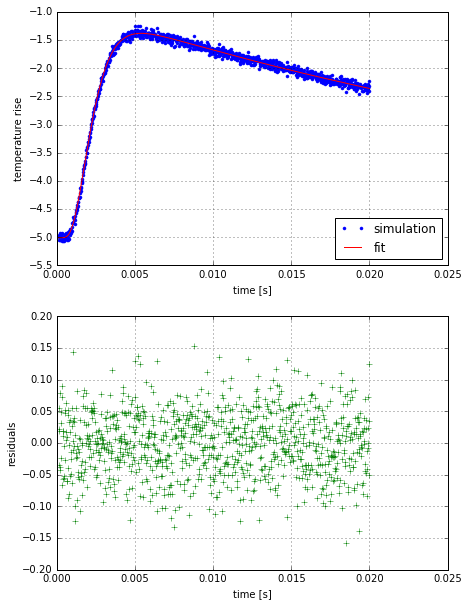

Relative errors [baseline level, Tmax, thermal diffusivity, Biot number] in percent are: 
 [ 0.15885274  0.02106794  0.28695395 -0.85776077]

 
 Histogram of residuals


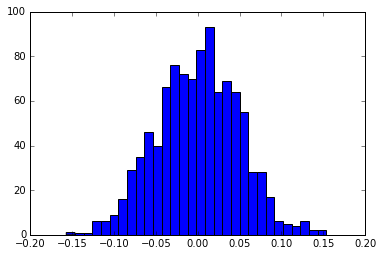

In [10]:
B = myoutput.beta # final results of calculated optimal parameters
Bio=[B[3],B[3],B[3]*L/R]
gamas = mroots(funA, Bio, 0.0001, 200)
betas = mroots(funR, Bio, 0.0001, 200) 
theory = B[0]+B[1]*flash2DHLe(time, B[2], Bio, gamas, betas,tp1) 


fig = pyplot.figure(figsize=(7, 10)) 

pyplot.figure(1)
pyplot.subplot(211)
pyplot.plot(time, temperature1n, 'b.', label="simulation")
pyplot.plot(time, theory,'r', label="fit")
pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.legend(loc=4)
pyplot.grid()

residuals = temperature1n - theory

pyplot.subplot(212)
pyplot.plot(time, residuals, 'g+', label="residuals")
pyplot.xlabel("time [s]")
pyplot.ylabel("residuals")
pyplot.grid()

pyplot.show()

pyplot.hist(residuals, 30) # plot histogram of residuals

# calculate relative errors
errors = (B-theors)/theors*100 
errors
print ("Relative errors [baseline level, Tmax,"
       +" thermal diffusivity, Biot number] in percent are: \n",
       errors)
print ("\n \n Histogram of residuals")


## The End